In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sharumaan_semimages_299x299_path = kagglehub.dataset_download('sharumaan/semimages-299x299')

print('Data source import complete.')


100%|██████████| 763M/763M [00:05<00:00, 148MB/s]

Extracting files...


Data source import complete.


# Automated image classification of defects in SEM images

In [4]:
!pip install natsort --quiet
# !conda install -y natsort

In [5]:
import os
from os.path import expanduser
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import logging
import datetime
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding (這邊修改過，改成新的版本)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [11]:
# 在 Colab 執行這段

base_url = "https://b2share.eudat.eu/records/qtq9v-ys023/files"

classes = [
    "Biological",
    "Fibres",
    "Films_Coated_Surface",
    "MEMS_devices_and_electrodes",
    "Nanowires",
    "Particles",
    "Patterned_surface",
    "Porous_Sponge",
    "Powder",
    "Tips",
]

for cname in classes:
    url = f"{base_url}/{cname}.tar?download=1"
    out_name = f"{cname}.tar"
    print("Downloading:", url)
    !wget -O "$out_name" "$url"


Downloading: https://b2share.eudat.eu/records/qtq9v-ys023/files/Biological.tar?download=1
--2025-12-01 22:46:56--  https://b2share.eudat.eu/records/qtq9v-ys023/files/Biological.tar?download=1
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.117, 2001:708:10:6802::12
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 700318720 (668M) [application/octet-stream]
Saving to: ‘Biological.tar’

Biological.tar      100%[===================>] 667.88M  21.6MB/s    in 33s     

2025-12-01 22:47:29 (20.5 MB/s) - ‘Biological.tar’ saved [700318720/700318720]

Downloading: https://b2share.eudat.eu/records/qtq9v-ys023/files/Fibres.tar?download=1
--2025-12-01 22:47:29--  https://b2share.eudat.eu/records/qtq9v-ys023/files/Fibres.tar?download=1
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.117, 2001:708:10:6802::12
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.117|:443... connected.

In [12]:
import os
import tarfile

extract_root = "/content/sem_dataset"
os.makedirs(extract_root, exist_ok=True)

classes = [
    "Biological",
    "Fibres",
    "Films_Coated_Surface",
    "MEMS_devices_and_electrodes",
    "Nanowires",
    "Particles",
    "Patterned_surface",
    "Porous_Sponge",
    "Powder",
    "Tips",
]

for cname in classes:
    tar_path = f"{cname}.tar"
    print("Extracting:", tar_path)
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=extract_root)

!ls -R /content/sem_dataset


Extracting: Biological.tar


/tmp/ipython-input-2738957074.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_root)


串流輸出內容已截斷至最後 5000 行。
L1_4b0c638b592182ba1921427e4b5e63f1.jpg
L1_4b1c759d7d8ad07db29bf3e400cd21fb.jpg
L1_4b38f83bfe9b4a1114c4a67491742d81.jpg
L1_4b6cf9e2a665417bdc37f897887e061b.jpg
L1_4b6face1affeeaf0782a81679a4d02cd.jpg
L1_4b7827c8446d5c066e751ac6da73cf1b.jpg
L1_4b809a8a13e88ecb0f52daf5cf7dca72.jpg
L1_4b89de6459d7c37912183d69e889920b.jpg
L1_4ba2fde057c2aa847fd01a9c51fe9a01.jpg
L1_4ba32c7d0da0d0c48bc2e79fabd87226.jpg
L1_4bdc7c440d441f78ca3aa37feb079304.jpg
L1_4bec28628cae4c371429d15069ea73f2.jpg
L1_4c05bf0b759b11e8d8845da2da1befbf.jpg
L1_4c32e921d19c5eb694669153d7d95261.jpg
L1_4c4ff0b2b2adef5dab6f8c0e7e5e45f6.jpg
L1_4c6653964ce9438641d3a7808cfb4056.jpg
L1_4c77b0b6ad9bfb04fc825f71dd2f835b.jpg
L1_4c8c60955a24a44121fa541d2714db92.jpg
L1_4c9aeeaf6d9517313b0de935eab74304.jpg
L1_4cb3bcd0bb7afb69c61d3a2730fa34a6.jpg
L1_4cc73554f2dea5a9f56508a50c86f7c9.jpg
L1_4ccc6c165eebec5c2b762081123deca3.jpg
L1_4cd72ecda50948f6e173bccf7b272cd3.jpg
L1_4ce38db8494ec695bf655f846fd19f29.jpg
L1_4cee42decb11f540

檢查一下資料結構

In [13]:
import os

data_root = "/content/sem_dataset"

for cname in sorted(os.listdir(data_root)):
    cpath = os.path.join(data_root, cname)
    if os.path.isdir(cpath):
        n_imgs = len([f for f in os.listdir(cpath)
                      if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"))])
        print(f"{cname:30s} -> {n_imgs} images")


Biological                     -> 953 images
Fibres                         -> 153 images
Films_Coated_Surface           -> 308 images
MEMS_devices_and_electrodes    -> 4158 images
Nanowires                      -> 3656 images
Particles                      -> 3412 images
Patterned_surface              -> 3310 images
Porous_Sponge                  -> 171 images
Powder                         -> 895 images
Tips                           -> 1561 images


切 train / val / test（實際複製檔案到新資料夾）

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

def collect_image_paths(root_dir, exts=IMAGE_EXTS):
    class_names = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    paths, labels = [], []
    for cname in class_names:
        cdir = os.path.join(root_dir, cname)
        for fname in os.listdir(cdir):
            if fname.lower().endswith(exts):
                paths.append(os.path.join(cdir, fname))
                labels.append(cname)

    print(f"Found {len(paths)} images in {len(class_names)} classes:")
    print(class_names)
    return paths, labels, class_names


def make_splits(root_dir, out_dir,
                test_size=0.15, val_size=0.15,
                random_state=42):
    paths, labels, class_names = collect_image_paths(root_dir)

    # 先切 test
    X_temp, X_test, y_temp, y_test = train_test_split(
        paths, labels,
        test_size=test_size,
        stratify=labels,
        random_state=random_state
    )

    # 再切 val（相對於剩下的比例）
    val_ratio_relative = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_ratio_relative,
        stratify=y_temp,
        random_state=random_state
    )

    def _copy_split(X, y, split_name):
        for src, label in zip(X, y):
            dst_dir = os.path.join(out_dir, split_name, label)
            os.makedirs(dst_dir, exist_ok=True)
            dst = os.path.join(dst_dir, os.path.basename(src))
            shutil.copy2(src, dst)

    _copy_split(X_train, y_train, "train")
    _copy_split(X_val,   y_val,   "val")
    _copy_split(X_test,  y_test,  "test")

    print("Done splitting.")
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    return {
        "class_names": class_names,
        "train": (X_train, y_train),
        "val":   (X_val,   y_val),
        "test":  (X_test,  y_test),
    }

# 實際執行
root_dir = "/content/sem_dataset"
out_dir  = "/content/sem_dataset_splits"

splits_info = make_splits(root_dir, out_dir,
                          test_size=0.15,
                          val_size=0.15,
                          random_state=42)

!ls -R /content/sem_dataset_splits


串流輸出內容已截斷至最後 5000 行。
L1_dae8caf0731f79fea9b73a5af1501d69.jpg
L1_daf58d628228b6cecd9f5eb3447a6886.jpg
L1_dafedd71db1c9fad0239e16345aa1f09.jpg
L1_db1ef20e0819043d33b34c5b8c084081.jpg
L1_dbada9f5d7be173c708f810127e1e150.jpg
L1_dbbebb7ea7e21a745a9bc9075b2c8851.jpg
L1_dbc9a0314bdcc59da35014902b867d79.jpg
L1_dbd0e69c0ff5885614ab80abbcc4fb32.jpg
L1_dbef4c8d7802c8d956adfeffc6383acd.jpg
L1_dbfcc4c52d9f857a7e16ffb2a418e8d0.jpg
L1_dc08cd845141d62187100598aa0826e1.jpg
L1_dc1930e8a6a1bf638c545105d312519b.jpg
L1_dc2975529b26df0a322a9dc2f79f96aa.jpg
L1_dc4401b086914eee87e6b46fbc148ed9.jpg
L1_dc4d127cdf05c4e95a9d8c60ed40d3a5.jpg
L1_dc69b95b7e92d284258906be251c68c8.jpg
L1_dc70dffedc54ee86221663cd0fc58af6.jpg
L1_dc754b362373b6b2dd34411b73c6c269.jpg
L1_dc78b73dd139395e09170a561bb8d9e6.jpg
L1_dc7a00f6bc15fa6cdee3a922e20d49f2.jpg
L1_dc886c73fa5361b15c68461aff88be59.jpg
L1_dcc3bfde4c7bf1021c70493ecfee4007.jpg
L1_dcebeb8d3d114cf055d0cb41be5bf95d.jpg
L1_dcecac93692ac691bef9bfecdb1062c6.jpg
L1_dcf4462227e30fc9

建立 ImageDataGenerator（資料增強 + dataloader）

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_root = "/content/sem_dataset_splits"
img_size = (299, 299)   # InceptionV3 預設 299x299
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(data_root, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    directory=os.path.join(data_root, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_datagen.flow_from_directory(
    directory=os.path.join(data_root, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 13003 images belonging to 10 classes.
Found 2787 images belonging to 10 classes.
Found 2787 images belonging to 10 classes.


建立 InceptionV3 transfer learning 模型

In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

num_classes = train_gen.num_classes  # 應該是 10
input_shape = (299, 299, 3)

base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# 先凍結 backbone
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,329,898 (85.18 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

compile + 訓練（第一階段：只訓練最後幾層）

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    "best_sem_cnn.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

epochs = 5

history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=50,
    validation_data=val_gen,
    validation_steps=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7123 - loss: 0.8871
Epoch 1: val_accuracy improved from -inf to 0.82344, saving model to best_sem_cnn.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 626s 12s/step - accuracy: 0.7127 - loss: 0.8857 - val_accuracy: 0.8234 - val_loss: 0.5906 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7367 - loss: 0.7877
Epoch 2: val_accuracy did not improve from 0.82344
50/50 ━━━━━━━━━━━━━━━━━━━━ 618s 12s/step - accuracy: 0.7369 - loss: 0.7875 - val_accuracy: 0.8219 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7534 - loss: 0.7223
Epoch 3: val_accuracy improved from 0.82344 to 0.82500, saving model to best_sem_cnn.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 625s 13s/step - accuracy: 0.7534 - loss: 0.7220 - val_accuracy: 0.8250 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7796 - loss: 0.6342
Epoch 4: val_accuracy did not improve from 0.82500
50/50 ━━━━━━━━━━━━━━━━━━━━ 619s 12s/step - accuracy: 0.7796 - loss: 0.6348 - val_accuracy: 0.8062 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7997 - loss: 0.6365
Epoch 5: val_accuracy improved from 0.82500 to 0.83281, saving model to best_sem_cnn.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 626s 13s/step - accuracy: 0.7993 - loss: 0.6369 - val_accuracy: 0.8328 - val_loss: 0.5230 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


跑太久了，調整 batch size

這一輪是「凍結 InceptionV3，只訓練你自己加上去的分類 head」。

在 test set 上評估

In [21]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test loss = {test_loss:.4f}, Test accuracy = {test_acc:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 748s 8s/step - accuracy: 0.8406 - loss: 0.5200
Test loss = 0.5330, Test accuracy = 0.8278


混淆矩陣 + classification report

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 真實標籤
y_true = test_gen.classes
class_indices = test_gen.class_indices  # {'Biological':0, ...}
idx_to_class = {v: k for k, v in class_indices.items()}

# 預測
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (raw counts):")
print(cm)

# 每一類的 precision / recall / f1-score
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=target_names))


88/88 ━━━━━━━━━━━━━━━━━━━━ 748s 8s/step
Confusion matrix (raw counts):
[[137   0   0   0   2   4   0   0   0   0]
 [  1   6   0   7   6   0   3   0   0   0]
 [  6   0   0   1   4  30   1   0   4   0]
 [ 11   0   0 564   3   3  41   0   0   2]
 [ 21   0   0  25 450  32   5   0   4  11]
 [  8   0   0   3   5 490   3   0   0   3]
 [  1   0   0  65   2  42 382   0   0   5]
 [  3   0   0   2   1   4   1  15   0   0]
 [ 14   0   0   0   3  26   0   1  90   0]
 [  7   0   0  24   8  10  12   0   0 173]]

Classification report:
                             precision    recall  f1-score   support

                 Biological       0.66      0.96      0.78       143
                     Fibres       1.00      0.26      0.41        23
       Films_Coated_Surface       0.00      0.00      0.00        46
MEMS_devices_and_electrodes       0.82      0.90      0.86       624
                  Nanowires       0.93      0.82      0.87       548
                  Particles       0.76      0.96      0.85 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


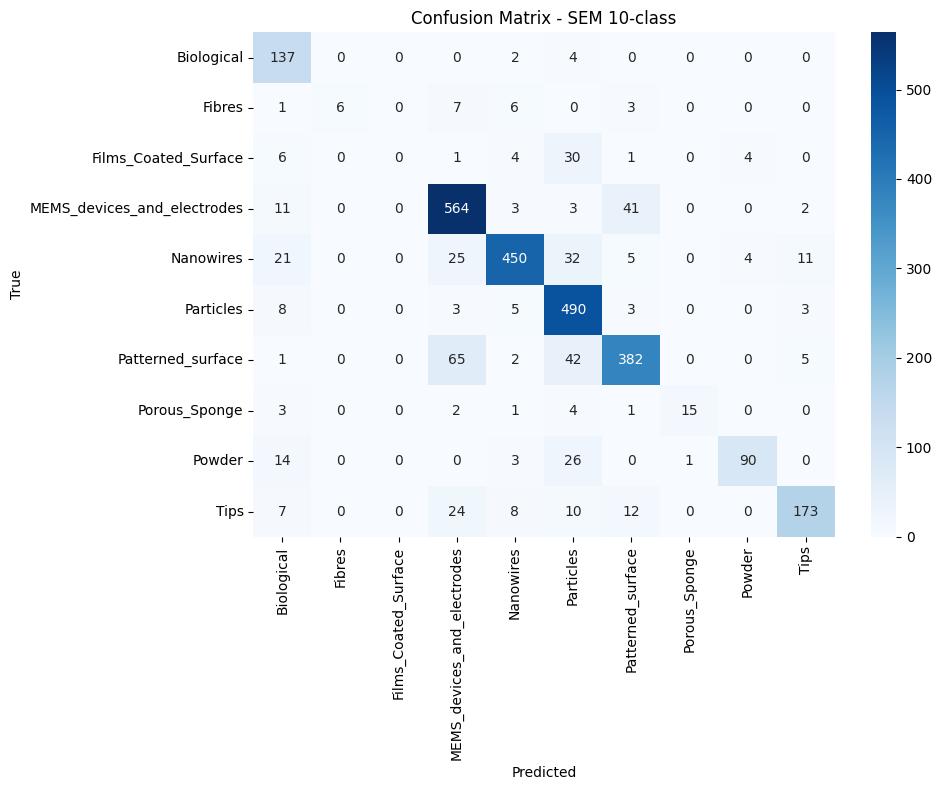

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SEM 10-class")
plt.tight_layout()
plt.show()


Batch shape: (32, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
True label:      Biological
Predicted label: Biological
Class probabilities:
  Biological                    : 0.9219
  Fibres                        : 0.0002
  Films_Coated_Surface          : 0.0002
  MEMS_devices_and_electrodes   : 0.0010
  Nanowires                     : 0.0677
  Particles                     : 0.0022
  Patterned_surface             : 0.0002
  Porous_Sponge                 : 0.0049
  Powder                        : 0.0009
  Tips                          : 0.0009


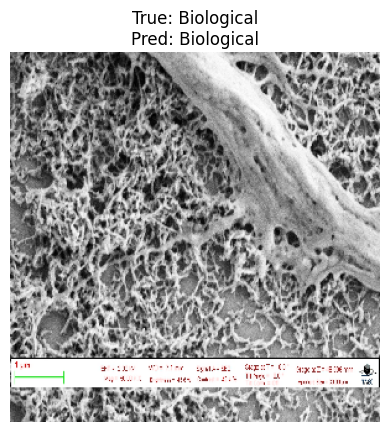

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 從 test_gen 拿一個 batch
x_batch, y_batch = next(test_gen)  # x: 影像, y: one-hot label
print("Batch shape:", x_batch.shape)

# 2. 取 batch 中的第 0 張
img = x_batch[0]
true_label_idx = np.argmax(y_batch[0])

# 3. 預測
pred_prob = model.predict(np.expand_dims(img, axis=0))[0]
pred_idx = np.argmax(pred_prob)

# 4. 把 index 轉回類別名稱
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
true_label = idx_to_class[true_label_idx]
pred_label = idx_to_class[pred_idx]

print("True label:     ", true_label)
print("Predicted label:", pred_label)
print("Class probabilities:")
for i, p in enumerate(pred_prob):
    print(f"  {idx_to_class[i]:30s}: {p:.4f}")

# 5. 把這張圖畫出來看看
plt.imshow(img)      # 已經是 rescale 後的 0~1 圖片
plt.axis("off")
plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Image path: /content/sample_data/sem_sample/NiCo-5.png
Predicted label: Particles
Class probabilities:
  Biological                    : 0.0166
  Fibres                        : 0.0036
  Films_Coated_Surface          : 0.0020
  MEMS_devices_and_electrodes   : 0.0259
  Nanowires                     : 0.0473
  Particles                     : 0.8122
  Patterned_surface             : 0.0231
  Porous_Sponge                 : 0.0186
  Powder                        : 0.0129
  Tips                          : 0.0377


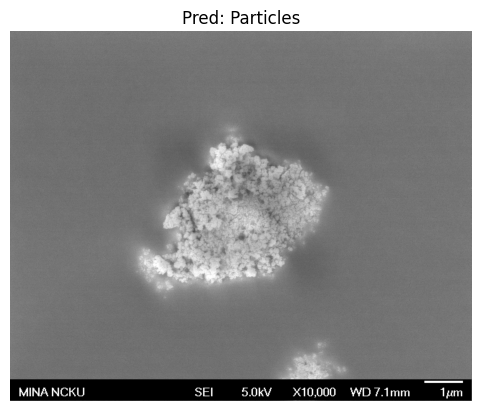

In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

# 如果你用 InceptionV3：img_size = (299, 299)
# 如果你後來改成 MobileNetV2：img_size = (160, 160)
img_size = (299, 299)  # 自己確認一下你前面用的是哪個

# 自己指定一張圖的路徑（範例：從 test 資料夾挑一張）
img_path = "/content/sample_data/sem_sample/NiCo-5.png"  # 這裡換成你自己的檔名

# 1. 讀圖 + resize
img = load_img(img_path, target_size=img_size)
img_arr = img_to_array(img)           # shape: (H, W, 3)
img_arr = img_arr / 255.0             # 跟 ImageDataGenerator 一樣 rescale
img_arr = np.expand_dims(img_arr, 0)  # shape: (1, H, W, 3)

# 2. 預測
pred_prob = model.predict(img_arr)[0]
pred_idx = np.argmax(pred_prob)

# 3. 轉回類別名稱
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
pred_label = idx_to_class[pred_idx]

print("Image path:", img_path)
print("Predicted label:", pred_label)
print("Class probabilities:")
for i, p in enumerate(pred_prob):
    print(f"  {idx_to_class[i]:30s}: {p:.4f}")

# 4. 顯示影像
plt.imshow(load_img(img_path))
plt.axis("off")
plt.title(f"Pred: {pred_label}")
plt.show()


<!-- 這個模型實際能做什麼？ -->

訓練完之後，你手上這個 model 本質上是一個：

「10 類 SEM 微結構自動分類模型」

只要給它一張新 SEM 圖：

它會輸出這張圖分別屬於
Biological / Fibres / Films_Coated_Surface / MEMS_devices_and_electrodes /
Nanowires / Particles / Patterned_surface / Porous_Sponge / Powder / Tips
的機率分布

你可以取 np.argmax 當「預測類別」

🧪 在實務上的用途可以是：

快速整理大量 SEM 圖

幾千張 SEM 自動分成 10 類，不用助教或學生一張一張搬

材料表徵自動化

例如看到 Powder / Porous_Sponge / Nanowires 的比例

在不同製程條件下比較某類微結構的出現頻率

品質管制（QA）初步篩選

例如 MEMS devices 的電極 SEM 有沒有出現特定 Patterned_surface 或 Powder 類缺陷

後續更高階任務的 backbone

當 feature extractor：
再接 segmentation、缺陷偵測、clustering 等任務

把中間層特徵抽出來做 unsupervised representation learning（跟你 PBL #2 那條線可以接在一起）